In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv


In [2]:
#imports
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
import os

# import imageio
from matplotlib import image


from sklearn.metrics import accuracy_score

# import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Convolution2D, Flatten, MaxPooling2D, Reshape, InputLayer
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.preprocessing.image import load_img

In [3]:
#parsing data into train and validation:
data = pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')

In [4]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
#function parses data into train/val/test
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [6]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [7]:
#reshaping our image matrices & normalizing:

train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
X_train = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
X_val = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
X_test = test_images.astype('float32')/255



In [8]:
#hot encoding our y vectors:
y_train = keras.utils.to_categorical(train_image_label)
y_val = keras.utils.to_categorical(val_image_label)
y_test = keras.utils.to_categorical(test_image_label)

In [9]:
#creating a DF for y_train data:
pd.DataFrame(y_train)

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
28704,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28705,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28706,0.0,0.0,0.0,0.0,1.0,0.0,0.0
28707,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#adding a data augmenter to bolster model accuracy on unseen images:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [11]:
# define vars
input_reshape = (48, 48, 1)

pool_size = (2, 2)

hidden_num_units = 265
output_num_units = 7

epochs = 10
batch_size = 128

In [12]:
#creating Sequential CNN:

model = Sequential([

Convolution2D(75,(2,2), activation='relu',input_shape=input_reshape),
MaxPooling2D((2,2)),

Convolution2D(50,(2,2), activation='relu'),
MaxPooling2D((2,2)),

Convolution2D(25,(2,2), activation='relu'),

Flatten(),

Dense(hidden_num_units, 'relu'),

Dense(output_num_units,'softmax'),
 ])


In [13]:
#printing model summary:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 75)        375       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 50)        15050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 25)        5025      
_________________________________________________________________
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
dense (Dense)                (None, 265)               6

In [14]:
#fitting model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

trained_model_conv = model.fit(X_train, y_train, epochs =epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
225/225 [==============================] - 7s 14ms/step - loss: 1.7688 - accuracy: 0.2874 - val_loss: 1.5320 - val_accuracy: 0.4113
Epoch 2/10
225/225 [==============================] - 2s 9ms/step - loss: 1.5004 - accuracy: 0.4282 - val_loss: 1.4336 - val_accuracy: 0.4419
Epoch 3/10
225/225 [==============================] - 2s 10ms/step - loss: 1.3801 - accuracy: 0.4740 - val_loss: 1.3548 - val_accuracy: 0.4804
Epoch 4/10
225/225 [==============================] - 2s 10ms/step - loss: 1.2760 - accuracy: 0.5095 - val_loss: 1.3306 - val_accuracy: 0.4829
Epoch 5/10
225/225 [==============================] - 2s 10ms/step - loss: 1.2201 - accuracy: 0.5319 - val_loss: 1.2477 - val_accuracy: 0.5205
Epoch 6/10
225/225 [==============================] - 2s 10ms/step - loss: 1.1279 - accuracy: 0.5759 - val_loss: 1.2592 - val_accuracy: 0.5249
Epoch 7/10
225/225 [==============================] - 2s 9ms/step - loss: 1.0554 - accuracy: 0.6017 - val_loss: 1.2341 - val_accuracy: 0.5350
E

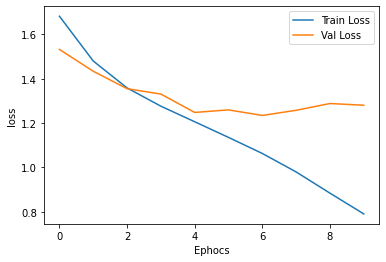

In [15]:
#plotting model loss curves:
import matplotlib.pyplot as plt
plt.plot(trained_model_conv.history['loss'],label='Train Loss')
plt.plot(trained_model_conv.history['val_loss'],label='Val Loss')
plt.xlabel('Ephocs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [16]:
#increasing model complexity by adding more convo layers:
model = Sequential()
#Block-1
model.add(Convolution2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = input_reshape))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Convolution2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#Block-2
model.add(Convolution2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = input_reshape))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Convolution2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#Block-3
model.add(Convolution2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = input_reshape))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Convolution2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#Block-4
model.add(Convolution2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = input_reshape))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Convolution2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#Block-5
model.add(Flatten())
model.add(Dense(units = 256 , activation = 'relu'))
model.add(Dropout(0.3))

#Block-6
model.add(Dense(units = 7 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 256)       2560      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 256)       590080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 128)       295040    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 128)        

In [17]:
#importing regularization techniqhes from keras
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [18]:
checkpoint = ModelCheckpoint('EmotionDetectionModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)
callbacks = [earlystop,checkpoint,reduce_lr]

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

trained_model_conv = model.fit(X_train, y_train, epochs =20, batch_size=128,callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/20
225/225 [==============================] - 9s 36ms/step - loss: 1.8435 - accuracy: 0.2482 - val_loss: 1.8192 - val_accuracy: 0.2449

Epoch 00001: val_loss improved from inf to 1.81921, saving model to EmotionDetectionModel.h5
Epoch 2/20
225/225 [==============================] - 8s 34ms/step - loss: 1.8158 - accuracy: 0.2494 - val_loss: 1.8158 - val_accuracy: 0.2449

Epoch 00002: val_loss improved from 1.81921 to 1.81578, saving model to EmotionDetectionModel.h5
Epoch 3/20
225/225 [==============================] - 8s 34ms/step - loss: 1.8125 - accuracy: 0.2522 - val_loss: 1.7502 - val_accuracy: 0.2803

Epoch 00003: val_loss improved from 1.81578 to 1.75018, saving model to EmotionDetectionModel.h5
Epoch 4/20
225/225 [==============================] - 8s 34ms/step - loss: 1.7261 - accuracy: 0.2910 - val_loss: 1.6070 - val_accuracy: 0.3449

Epoch 00004: val_loss improved from 1.75018 to 1.60703, saving model to EmotionDetectionModel.h5
Epoch 5/20
225/225 [====================

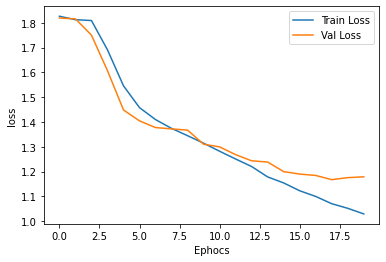

In [20]:
#showing model loss curves:

plt.plot(trained_model_conv.history['loss'],label='Train Loss')
plt.plot(trained_model_conv.history['val_loss'],label='Val Loss')
plt.xlabel('Ephocs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [21]:
model.weights

[<tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 1, 256) dtype=float32, numpy=
 array([[[[-1.71468109e-02,  1.52471468e-01, -4.57982793e-02, ...,
            5.44004738e-02, -7.17634335e-02, -8.33098739e-02]],
 
         [[-8.10214132e-02,  2.27757618e-02, -6.13482259e-02, ...,
            9.34161618e-02, -1.91432387e-02, -1.32937476e-01]],
 
         [[-8.61897096e-02, -1.53869748e-01, -4.52895835e-02, ...,
           -3.00782155e-02, -9.20439418e-03, -6.61158487e-02]]],
 
 
        [[[-7.57844597e-02,  5.28440401e-02, -6.27312250e-03, ...,
           -1.12880185e-01, -6.48429021e-02, -5.71985766e-02]],
 
         [[-5.35137840e-02, -5.44253886e-02,  1.48394480e-02, ...,
           -1.78930268e-01, -5.37727289e-02, -2.16128537e-03]],
 
         [[ 3.01837828e-02, -1.22698769e-01, -5.51713593e-02, ...,
           -8.79794657e-02,  2.09397413e-02,  1.17189370e-01]]],
 
 
        [[[-2.08031535e-02,  1.32652298e-01, -8.30871140e-05, ...,
           -4.36039083e-02,  3.97587894e-03,  2.2095

In [31]:
#using model to predict an angry facial expression:
import numpy as np
from numpy import asarray
# Importing Image and ImageOps module from PIL package
from PIL import Image, ImageOps

img = Image.open('../input/angry-face-image/angry_face.JPG')
img = ImageOps.grayscale(img)

new_image = img.resize((48, 48))

angry_face_resized_arr = asarray(new_image)


angry_face = angry_face_resized_arr.reshape((1, 48, 48, 1))

print(angry_face.shape)

(1, 48, 48, 1)


In [34]:
model.predict_classes(angry_face)

#model predicts suprised

array([5])

In [35]:
#using model to predict a happy facial expression:
import numpy as np
from numpy import asarray
# Importing Image and ImageOps module from PIL package
from PIL import Image, ImageOps

img = Image.open('../input/happy-face/happy_face.JPG')
img = ImageOps.grayscale(img)

new_image = img.resize((48, 48))

happy_face_resized_arr = asarray(new_image)


happy_face = happy_face_resized_arr.reshape((1, 48, 48, 1))

print(happy_face.shape)

(1, 48, 48, 1)


In [39]:
model.predict(happy_face)

#model predicts sad

array([[2.7434794e-09, 7.4201685e-34, 5.2656922e-08, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [41]:
#using model to predict a sad facial expression:

import numpy as np
from numpy import asarray
# Importing Image and ImageOps module from PIL package
from PIL import Image, ImageOps

img = Image.open('../input/sad-face/sad_face.JPG')
img = ImageOps.grayscale(img)

new_image = img.resize((48, 48))

sad_face_resized_arr = asarray(new_image)

sad_face = sad_face_resized_arr.reshape((1, 48, 48, 1))

print(sad_face.shape)

(1, 48, 48, 1)


In [52]:
model.predict_classes(sad_face)

#model predicted suprised

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([5])

0.5650599052660908


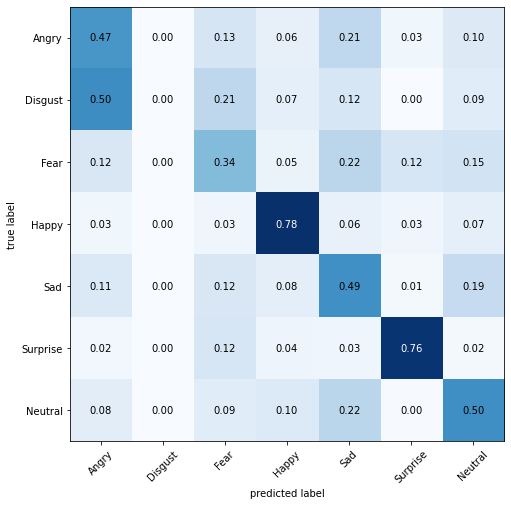

In [55]:
# Plotting confusion matrix & raw accuracy
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

test_preds = model.predict(X_test).argmax(axis=1)

#finding accuracy:
right_predict = 0
for pemotion,a_emotion in zip(test_preds,test_image_label):
    if pemotion==a_emotion:
        right_predict+=1
print(right_predict/len(test_preds))
    
#printing confusion matrix
conf_mat = confusion_matrix(test_image_label, test_preds)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))

# Conculsion: Model is able to somewhat accurately perform multinomial classification on emotions based on pictures (~60%). This is exciting.